In [1]:
from pathlib import Path
from tqdm import tqdm
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image

from sklearn.metrics import confusion_matrix, classification_report
import time

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

/home/khoa-ys/Projects/venv_for_projects/bio_ml_venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using cuda device


### Load data and divide into train and test set:

In [2]:
root_path = os.path.dirname(os.getcwd())
data_path = os.path.join(root_path, "shortened_dataset")
image_dict = json.load(open(os.path.join(data_path, 'image_dict.json'), 'r'))
train_image_dict = {}
test_image_dict = {}
val_image_dict = {}
for tumor_type in list(image_dict.keys()):
    train_image_dict[tumor_type] = image_dict[tumor_type][:]
    val_image_dict[tumor_type] = image_dict[tumor_type][120:150]
    test_image_dict[tumor_type] = image_dict[tumor_type][150:]
print(*image_dict.keys(), sep=', ')

Astrocitoma, Carcinoma, Ependimoma, Glioblastoma, Meningioma, Neurocitoma, Oligodendroglioma, Papiloma, Schwannoma, Tuberculoma, _NORMAL


In [3]:
class BrainTumorDataset(Dataset):
    def __init__(self, image_dict, data_path, transform=None, transform_label=None):
        self.data_path = data_path
        self.image_dict = image_dict
        self.classes = list(image_dict.keys())
        self.image_class_list = [(item, key) for key, item_list in image_dict.items() for item in item_list]
        self.transform = transform
        self.transform_label = transform_label

    def __len__(self):
        return len(self.image_class_list)

    def __getitem__(self, idx):
        label = self.classes.index(self.image_class_list[idx][1])
        img_path = os.path.join(self.data_path, self.image_class_list[idx][0])
        image = cv2.imread(img_path, 0)
        if self.transform:
            image = self.transform(image)
        if self.transform_label:
            label = self.transform_label(label)
        return image, label

### VAE model:

In [4]:
class VAE(nn.Module):
    def __init__(self, latent_dim=2):
        super().__init__()
        # Encoder
        self.encoder = nn.Sequential(nn.Conv2d(1, 8, kernel_size=3, stride=2, padding=1),
                                     nn.ReLU(inplace=True),
                                     nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
                                     nn.ReLU(inplace=True),
                                     nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
                                     nn.ReLU(inplace=True),
                                     nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=0),
                                     nn.ReLU(inplace=True))
        self.fc1 = nn.Linear(64*15*15, 128)
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_log_var = nn.Linear(128, latent_dim)
        
        # Decoder
        self.fc2 = nn.Linear(latent_dim, 128)
        self.fc3 = nn.Linear(128, 64*15*15)
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(64, 15, 15))
        self.decoder = nn.Sequential(nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2),
                                     nn.ReLU(inplace=True),
                                     nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, output_padding=1),
                                     nn.ReLU(inplace=True),
                                     nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=1, output_padding=1),
                                     nn.ReLU(inplace=True),
                                     nn.ConvTranspose2d(8, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
                                     nn.ReLU(inplace=True))
        self.softmax = nn.Softmax()
    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling
        return sample
    
    def encode(self, x):
        x = self.encoder(x)
        """
        batch, _, _, _ = x.shape
        x = F.adaptive_avg_pool2d(x, 1).reshape(batch, -1)
        x = self.fc1(x)
        """
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        # get `mu` and `log_var`
        mu = self.fc_mu(x)
        log_var = self.fc_log_var(x)
        return mu, log_var
    
    def decode(self, sample):
        # decoding
        """
        z = self.fc2(sample)
        z = z.view(-1, 128, 1, 1)
        """
        z = F.relu(self.fc2(sample))
        z = F.relu(self.fc3(z))
        z = self.unflatten(z)
        x = self.decoder(z)
        reconstruction = torch.sigmoid(x)
        return reconstruction

### Training and evaluation

#### Hyperparameters set

In [5]:
learning_rate = 3e-5
batch_size = 32
epochs = 50
latent_dim = 2
weight = 0.8

#### Load dataset into Dataloaders

Feature batch shape: torch.Size([32, 1, 256, 256])
Labels batch shape: torch.Size([32])


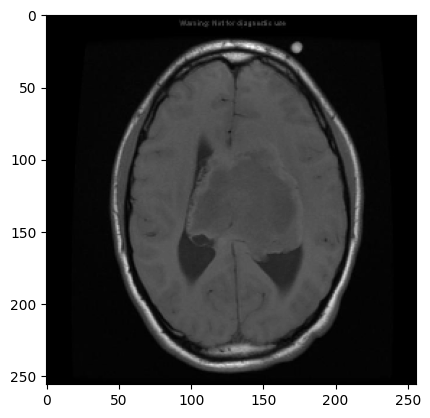

Label: 5


In [6]:
train_dataset = BrainTumorDataset(train_image_dict, data_path, transform=transforms.ToTensor())
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = BrainTumorDataset(test_image_dict, data_path, transform=transforms.ToTensor())
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

val_dataset = BrainTumorDataset(val_image_dict, data_path, transform=transforms.ToTensor())
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
image = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(image, cmap="gray")
plt.show()
print(f"Label: {label}")

#### Load model and modify

In [7]:
model = VAE(latent_dim=latent_dim)
model.to(device)

VAE(
  (encoder): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (7): ReLU(inplace=True)
  )
  (fc1): Linear(in_features=14400, out_features=128, bias=True)
  (fc_mu): Linear(in_features=128, out_features=2, bias=True)
  (fc_log_var): Linear(in_features=128, out_features=2, bias=True)
  (fc2): Linear(in_features=2, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=14400, bias=True)
  (unflatten): Unflatten(dim=1, unflattened_size=(64, 15, 15))
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), outp

#### Training loop

In [8]:
MSE = nn.MSELoss()
#params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

------------ Epoch: 0 ------------
loss: 0.262522
Time elapsed: 3.6531925201416016
------------ Epoch: 1 ------------
loss: 0.182433
Time elapsed: 2.01503849029541
------------ Epoch: 2 ------------
loss: 0.178753
Time elapsed: 1.9690840244293213
------------ Epoch: 3 ------------
loss: 0.178361
Time elapsed: 1.8797991275787354
------------ Epoch: 4 ------------
loss: 0.178410
Time elapsed: 1.8974814414978027
------------ Epoch: 5 ------------
loss: 0.178412
Time elapsed: 1.8601102828979492
------------ Epoch: 6 ------------
loss: 0.178385
Time elapsed: 1.940403938293457
------------ Epoch: 7 ------------
loss: 0.178465
Time elapsed: 1.849078893661499
------------ Epoch: 8 ------------
loss: 0.178404
Time elapsed: 1.8831510543823242
------------ Epoch: 9 ------------
loss: 0.178447
Time elapsed: 1.9428730010986328
------------ Epoch: 10 ------------
loss: 0.178378
Time elapsed: 1.9166228771209717
------------ Epoch: 11 ------------
loss: 0.178361
Time elapsed: 1.9869732856750488
------

Text(0.5, 0, 'Epoch')

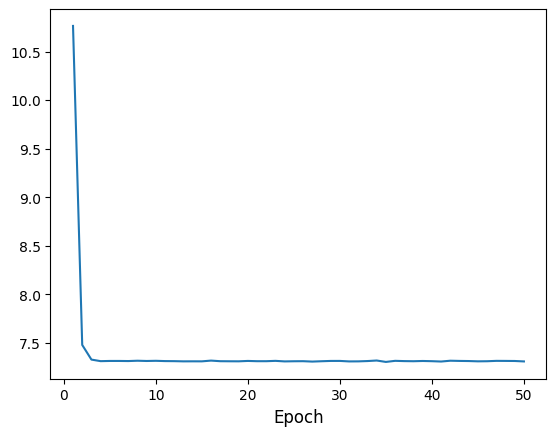

In [9]:
torch.cuda.empty_cache()
all_loss = []
for epoch in range(epochs):
    size = len(train_dataloader.dataset)
    print("------------ Epoch:", epoch, "------------")
    total_loss = 0
    start = time.time()
    for batch, (X, y) in enumerate(train_dataloader):
        X = X.to(device)
        mu, log_var = model.encode(X)
        KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        sample = model.reparameterize(mu, log_var)
        reconstructed_X = model.decode(sample)
        #print(X.size(), reconstructed_X.size())
        MSE_loss = MSE(X, reconstructed_X)
        #print(pred)
        loss = KLD + weight*MSE_loss

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #print(loss.item())
        total_loss += loss.item()
    print(f"loss: {total_loss/41:>7f}")
    end = time.time()
    print("Time elapsed:", end - start)
    all_loss.append(total_loss)

fig = plt.figure()
plt.plot(range(1, epochs+1), all_loss)
plt.xlabel('Epoch', fontsize=12)

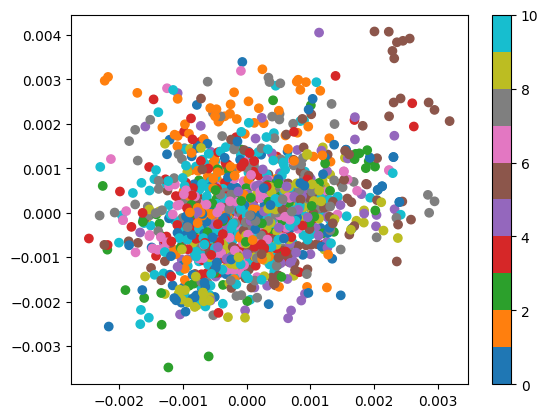

In [10]:
for batch, (X, y) in enumerate(train_dataloader):
    mu, log_var = model.encode(X.to(device))
    mu = mu.to('cpu').detach().numpy()
    plt.scatter(mu[:, 0], mu[:, 1], c=y, cmap='tab10')
    if batch > 41:
        plt.colorbar()
        break